In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
# !rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-12-03 08:35:58.017883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 08:35:58.237936: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 08:35:59.255562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_ensemble


In [2]:
penguin = pd.read_parquet('/kaggle/output/exp_ensemble/oof.parquet')
penguin.head()

,series_id,step,wakeup_oof,onset_oof
0,038441c925bb,0,0.003592,0.006805
1,038441c925bb,1,0.002768,0.005428
2,038441c925bb,2,0.001122,0.002674
3,038441c925bb,3,0.000308,0.001379
4,038441c925bb,4,0.000329,0.001545


In [3]:
import polars as pl
nikhil_v13 = pl.read_parquet("/kaggle/output/nikhil_output/v13.parquet").to_pandas()
nikhil_v13.head()

,series_id,step,onset,wakeup
0,038441c925bb,0,0.624577,-0.021164
1,038441c925bb,1,0.671710,-0.000398
2,038441c925bb,2,0.674564,0.015711
3,038441c925bb,3,0.661604,-0.014661
4,038441c925bb,4,0.676388,0.015270


In [4]:
nikhil_v15 = pl.read_parquet("/kaggle/output/nikhil_output/v15.parquet").to_pandas()
nikhil_v15.head()

,series_id,step,onset,wakeup
0,038441c925bb,0,0.786362,0.024583
1,038441c925bb,1,0.754581,0.016489
2,038441c925bb,2,0.926854,0.028489
3,038441c925bb,3,0.933176,-0.086153
4,038441c925bb,4,0.990766,-0.000131


In [5]:
assert all(nikhil_v13["series_id"] == nikhil_v15["series_id"])
assert all(nikhil_v13["step"] == nikhil_v15["step"])

In [6]:
nikhil = nikhil_v13
nikhil["onset_oof"] = nikhil_v13["onset"] * 0.5 + nikhil_v15["onset"] * 0.5
nikhil["wakeup_oof"] = nikhil_v13["wakeup"] * 0.5 + nikhil_v15["wakeup"] * 0.5

nikhil["onset_oof"] *= 0.5
nikhil["wakeup_oof"] *= 0.5

In [7]:
def todict(df):
    gb = df.groupby("series_id")
    sid2records = dict()
    for sid, df in gb:
        sid2records[sid] = df
    return sid2records

sid2records_penguin = todict(penguin)
sid2records_nikhil = todict(nikhil)
del penguin, nikhil
gc.collect()

0

In [8]:
dfs = []
for sid in tqdm(sid2records_penguin.keys()):
    penguin_df = sid2records_penguin[sid] if sid in sid2records_penguin else pd.DataFrame({"step": [0], "onset_oof": [0], "wakeup_oof": [0]})
    nikhil_df = sid2records_nikhil[sid] if sid in sid2records_nikhil else pd.DataFrame({"step": [0], "onset_oof": [0], "wakeup_oof": [0]})

    penguin_df = penguin_df.sort_values("step").reset_index(drop=True)
    nikhil_df = nikhil_df.sort_values("step").reset_index(drop=True)
    
    df = nikhil_df.rename(columns={"onset_oof": "onset_oof_nikhil", "wakeup_oof": "wakeup_oof_nikhil"})
    df["onset_oof_penguin"] = df["step"].map(penguin_df.set_index("step")["onset_oof"]) \
                                .interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_penguin"] = df["step"].map(penguin_df.set_index("step")["wakeup_oof"]) \
                                .interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    
    df["onset_oof"] = df["onset_oof_nikhil"] * 0.5 + df["onset_oof_penguin"] * 0.5
    df["wakeup_oof"] = df["wakeup_oof_nikhil"] * 0.5 + df["wakeup_oof_penguin"] * 0.5
    dfs.append(df)
    
    del nikhil_df, penguin_df
oof_df = pd.concat(dfs)
oof_df.to_parquet("/kaggle/output/exp_ensemble/final_oof.parquet", index=False)
oof_df = oof_df[oof_df["step"] % 12 == 6]
del dfs
gc.collect()

  0%|          | 0/277 [00:00<?, ?it/s]

100%|██████████| 277/277 [00:19<00:00, 14.02it/s]


0

11685781

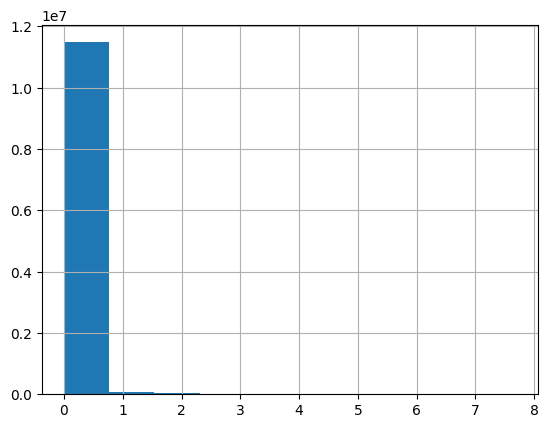

In [9]:
oof_df = oof_df[oof_df["step"] % 12 == 6]

dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.005]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.005]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["score"].hist()
len(train)

In [10]:
from multiprocessing import Pool

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 264/264 [00:29<00:00,  8.91it/s]


In [11]:
unused_series_ids = ['0ce74d6d2106', '0f9e60a8e56d', '154fe824ed87', '2fc653ca75c7',
       '390b487231ce', '44a41bba1ee7', '89c7daa72eee', 'a3e59c2ce3f6',
       'c5d08fc3e040', 'c7b1283bb7eb', 'e11b9d69f856', 'efbfc4526d58',
       'f8a8da8bdd00']

# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[~labels["series_id"].isin(unused_series_ids)]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "final_submission.csv"), index=False)

score: 0.8315


event   tolerance
onset   12           0.456080
        36           0.749449
        60           0.818990
        90           0.856073
        120          0.882323
        150          0.892974
        180          0.905183
        240          0.915428
        300          0.920307
        360          0.926578
wakeup  12           0.454579
        36           0.762820
        60           0.828271
        90           0.852640
        120          0.875116
        150          0.883440
        180          0.896649
        240          0.908327
        300          0.918623
        360          0.925860
dtype: float64